In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qibo.gates import M, X, RY, CZ, I, H
from qibo.models import Circuit
from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

from benchmarks.utils.qst_qpt_helper_functions import process_returned_dataformat

from itertools import product

# api = API(ConnectionConfiguration(username="qat", api_key="meow"))
api = API(ConnectionConfiguration(username="apalacios", api_key="3ec51562-3ff2-4f7b-add8-b21e1645a89d"))


api.select_device_id(9)

In [2]:
def get_chsh_circuits(bell_state, control_qubit, target_qubit, theta):
    assert bell_state in (
        "phi_plus",
        "phi_minus",
        "psi_plus",
        "psi_minus",
    ), "bell_state should be phi_plus, phi_minus, psi_plus, psi_minus"
    nqubits = max(control_qubit, target_qubit) + 1

    circuits = []
    for gate_a, gate_b in product([I, H], repeat=2):
        circuit = Circuit(nqubits)

        if bell_state == "phi_plus" or bell_state == "psi_minus":
            G1 = RY(control_qubit, theta=-np.pi / 2)
        else:
            G1 = RY(control_qubit, theta=np.pi / 2)
        if bell_state == "phi_plus" or bell_state == "phi_minus":
            G2_prime = RY(target_qubit, theta=-np.pi / 2)
        else:
            G2_prime = RY(target_qubit, theta=np.pi / 2)
        ## build bell state
        circuit.add(G1)
        circuit.add(RY(target_qubit, theta=np.pi / 2))
        circuit.add(CZ(control_qubit, target_qubit))
        circuit.add(G2_prime)

        ## decoder part
        circuit.add(RY(control_qubit, theta=theta))
        circuit.add(gate_a(control_qubit))
        circuit.add(gate_b(target_qubit))
        circuit.add(M(control_qubit, target_qubit))

        circuits.append(circuit)

    return circuits


def SPAM_circuits(control_qubit, target_qubit):
    """Circuits to get the SPAM matrix in order to perform measurement correction."""
    calibration_circuits = []
    for gate_a, gate_b in product([I, X], repeat=2):
        calibration_circuit = Circuit(5)
        calibration_circuit.add(gate_a(control_qubit))
        calibration_circuit.add(gate_b(target_qubit))
        calibration_circuit.add(M(control_qubit, target_qubit))

        calibration_circuits.append(calibration_circuit)
    return calibration_circuits


def compute_witnesses(chsh_results, measurement_calibration_weights, BELL_STATE, raw=False):
    """Returns arrays of computed witness values.

    Args:
        chsh_results (array): matrix containing the probabilities the chsh circuits. It must be
                        of dimensions len(theta_values) x 4 (decoder circuits) x 4 (probabilities)
        measurement_calibration_weights (array): measurement calibration matrix.
        BELL_STATE (string): can be "phi_plus", "phi_minus", "psi_plus" or "psi_minus". It needs
                            to be specified because the witness isn't the same for all 4 Bell states.
        raw (bool): whether or not calculate the witnesses from the raw data instead of applying the
                    measurement corrections. Defaults to False.
    Returns:
        witness1 (array): array length len(theta_values) containing the first witness
        witness2 (array): array length len(theta_values) containing the second witness
    """
    len_theta_values = np.shape(chsh_results)[0]
    witness1 = np.zeros(len_theta_values)
    witness2 = np.zeros(len_theta_values)

    if BELL_STATE == "phi_plus" or BELL_STATE == "psi_minus":
        signs1 = np.array([1, 1, -1, 1])
        signs2 = np.array([1, -1, 1, 1])
    else:
        signs1 = np.array([-1, 1, 1, 1])
        signs2 = np.array([1, 1, 1, -1])

    for i, chsh_result in enumerate(chsh_results):
        if raw != True:
            # apply measurement calibration
            chsh_result = measurement_calibration_weights @ chsh_result.T

        # calculate expectation values from probabilities
        expectations = np.array([1, -1, -1, 1]).T @ chsh_result

        # compute witnesses
        witness1[i] = signs1.T @ expectations
        witness2[i] = signs2.T @ expectations
    return witness1, witness2

In [3]:
CONTROL_QUBIT = 2
TARGET_QUBIT = 4
THETA_VALUES = np.linspace(-np.pi, np.pi, num=20)
BELL_STATE = "phi_plus"  # "psi_minus"

NUM_SHOTS = 8000

### Build circuits for CHSH and measurement correction

In [4]:
all_circuits_chsh = []
for theta in THETA_VALUES:
    circuits_th = get_chsh_circuits(BELL_STATE, CONTROL_QUBIT, TARGET_QUBIT, theta)
    all_circuits_chsh.extend(circuits_th)

all_circuits = SPAM_circuits(CONTROL_QUBIT, TARGET_QUBIT)

all_circuits.extend(all_circuits_chsh)

### Run circuits

In [5]:
result_id = api.execute(all_circuits, nshots=NUM_SHOTS)[0]

In [12]:
print("job id", result_id)

id chsh 7995
id SPAM 7996


In [30]:
api.list_jobs().dataframe[:10]

,user_id,device_id,status,job_type,number_shots,id
0,86,9,queued,circuit,8000,7997
1,86,9,completed,circuit,8000,7996
2,86,9,completed,circuit,8000,7995
3,86,9,completed,circuit,8000,7913
4,86,9,completed,circuit,8000,7912
5,86,9,completed,circuit,1000,7910
6,86,9,completed,circuit,1000,7909
7,86,9,completed,circuit,1000,7908
8,86,9,completed,circuit,1000,7907
9,86,9,completed,circuit,1000,7906


### Process real data

In [10]:
## retrieve data
results = api.get_result(result_id)
data_probabilities = process_returned_dataformat(results, nqubits=2)

## measurement calibration data processing
spam_data_probabilities = data_probabilities[:4]
measurement_calibration_weights = np.linalg.inv(spam_data_probabilities)

## chsh circuits data processing
chsh_data_probabilities = data_probabilities[4:]
chsh_data_probabilities_theta = chsh_data_probabilities.reshape(len(THETA_VALUES), 4, 4)

## compute witness
w1_raw, w2_raw = compute_witnesses(chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=True)
w1_corrected, w2_corrected = compute_witnesses(
    chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=False
)

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1705400857, time: 1705401003(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/jobs/8001"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1705400857, time: 1705401003(leeway: 60)"}

Your job with id 8001 is completed.


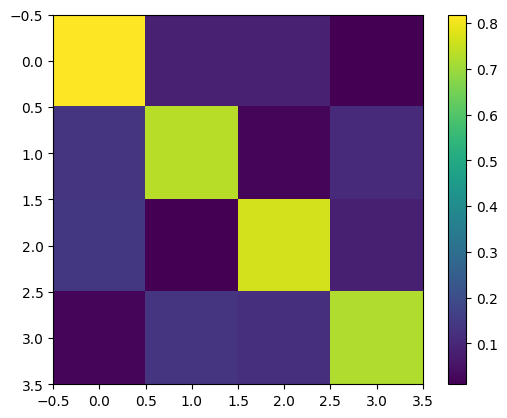

In [11]:
plt.imshow(spam_data_probabilities)
plt.colorbar()

### Run simulation, get ideal witnesses

In [12]:
circ_list = SPAM_circuits(0, 1)
ideal_results_spam = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_spam[i] += c.execute().probabilities()
ideal_measurement_calibration_weights = np.linalg.inv(ideal_results_spam)

circ_list = list(np.copy(all_circuits_chsh))
ideal_results_chsh = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_chsh[i] += c.execute().probabilities()

ideal_results_chsh_theta = ideal_results_chsh.reshape(len(THETA_VALUES), 4, 4)

w1_ideal, w2_ideal = compute_witnesses(
    ideal_results_chsh_theta, ideal_measurement_calibration_weights, BELL_STATE, raw=False
)

[Qibo 0.1.12.dev0|INFO|2024-01-16 11:30:13]: Using numpy backend on /CPU:0


### Plot results

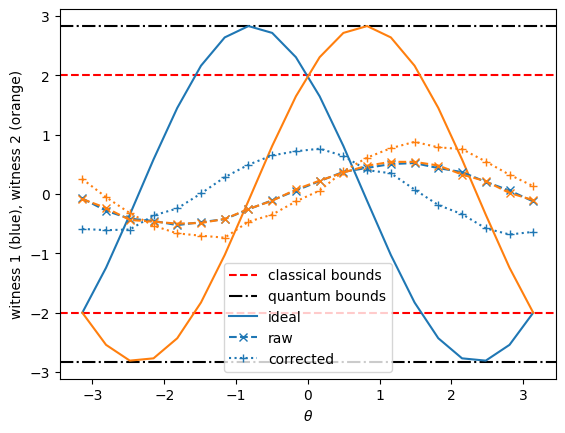

In [14]:
fname = f"chsh_{CONTROL_QUBIT}_{TARGET_QUBIT}_{BELL_STATE}_nshots{NUM_SHOTS}_jobid{result_id}.png"
savefig = False

fig, ax = plt.subplots()
ax.axhline(2, color="red", linestyle="--", label="classical bounds")
ax.axhline(-2, color="red", linestyle="--")
ax.axhline(2 * np.sqrt(2), color="k", linestyle="-.", label="quantum bounds")
ax.axhline(-2 * np.sqrt(2), color="k", linestyle="-.")

ax.plot(THETA_VALUES, w1_ideal, label="ideal")
ax.plot(THETA_VALUES, w2_ideal)  # , label = 'ideal')

ax.plot(THETA_VALUES, w1_raw, "x--", c="C0", label="raw")
ax.plot(THETA_VALUES, w2_raw, "x--", c="C1")  # , label = 'raw')

ax.plot(THETA_VALUES, w1_corrected, "+:", c="C0", label="corrected")
ax.plot(THETA_VALUES, w2_corrected, "+:", c="C1")  # , label = 'corrected')
ax.legend()

ax.set_xlabel("$\\theta$")
ax.set_ylabel("witness 1 (blue), witness 2 (orange)")

if savefig:
    fig.savefig(fname, bbox_inches="tight")